In [1]:
import fire_history
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# prevent gdal from printing errors to command prompt without throwing error
gdal.UseExceptions()

### Generating the data

**Edit the dropbox path** to be correct for your computer and run the following cell to generate daily fire footprints and static data (all but weather). This will take ~10 minutes and it is mostly the .gif generation. You can set ``gifs=False`` to avoid that, and it will take about 1 minute.

In [2]:
dropbox_path = r"C:\Users\mit\Dropbox (MIT)"

In [3]:
fire_history.preprocess(dropbox_path, gifs=False)

### Accessing fire footprints using gdal and numpy ###

In [4]:
inc_id = '11926606'

out_path = 'data/clean/fire_histories_revised'
fire_path = f'{out_path}/{inc_id}/daily_fire_footprint.vrt'

# read in the daily fire footprint database
ds = gdal.Open(fire_path)

# the key command: each day is a "raster" (layer) in the database
# this command reads a 2D-array from each day and stacks them together into a 3D array
arr = np.asarray([ds.GetRasterBand(i+1).ReadAsArray() for i in range(ds.RasterCount)])

In [5]:
# num_days, num_rows, num_cols
arr.shape

(30, 29, 46)

In [6]:
# here is how to access the name of the corresponding day
ds.GetRasterBand(1).GetDescription()

'2020-09-08'

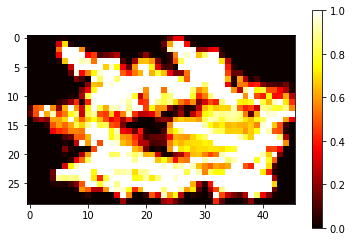

In [7]:
# we can visualize the "final" fire by taking the max value over all days
max_over_all_days = np.amax(arr, axis=0)

plt.set_cmap("hot")
plt.imshow(max_over_all_days)
plt.colorbar()

# clips the colorbar values at 1
plt.clim(0,1)

### Accessing static data ###

This will be helpful for transforming aspect/slope

#### For a single fire

In [8]:
path = f'{out_path}/{inc_id}'
path

'data/clean/fire_histories_revised/11926606'

In [9]:
ds = gdal.Open(f'{path}/static_data.vrt')
[evc, slope, aspect] = [ds.GetRasterBand(i) for i in [1, 2, 3]]

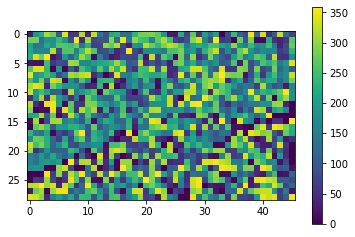

In [10]:
plt.set_cmap("viridis")
plt.imshow(aspect.ReadAsArray())
plt.colorbar()

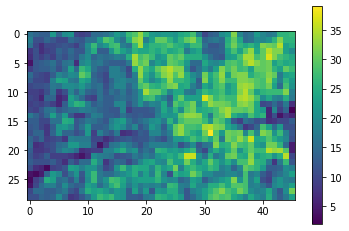

In [11]:
plt.imshow(slope.ReadAsArray())
plt.colorbar()

#### For an arbitrary region

In [12]:
df = pd.read_csv('data/input/static_data_params.csv')
df['path'] = dropbox_path + "\\" + df['path']

In [13]:
bounding_box = [-110, 32, -85, 40]
layer = 'aspect'

In [14]:
row = df.set_index('layer').loc[layer]
row

path      C:\Users\mit\Dropbox (MIT)\wildfire_repo\LF201...
impute                                                 near
Name: aspect, dtype: object

In [15]:
ds = gdal.Open(row['path'])

aspect = gdal.Warp(f'{layer}.vrt', ds, format='VRT', dstSRS='WGS84', xRes=0.01, yRes=0.01,
                  resampleAlg=row['impute'], outputBounds=bounding_box)

If you want to see what I did here, consult https://gdal.org/programs/gdalwarp.html along with

In [16]:
help(gdal.Warp)

Help on function Warp in module osgeo.gdal:

Warp(destNameOrDestDS, srcDSOrSrcDSTab, **kwargs)
    Warp one or several datasets.
    Arguments are :
      destNameOrDestDS --- Output dataset name or object
      srcDSOrSrcDSTab --- an array of Dataset objects or filenames, or a Dataset object or a filename
    Keyword arguments are :
      options --- return of gdal.WarpOptions(), string or array of strings
      other keywords arguments of gdal.WarpOptions()
    If options is provided as a gdal.WarpOptions() object, other keywords are ignored.



and

In [17]:
help(gdal.WarpOptions)

Help on function WarpOptions in module osgeo.gdal:

WarpOptions(options=None, format=None, outputBounds=None, outputBoundsSRS=None, xRes=None, yRes=None, targetAlignedPixels=False, width=0, height=0, srcSRS=None, dstSRS=None, coordinateOperation=None, srcAlpha=False, dstAlpha=False, warpOptions=None, errorThreshold=None, warpMemoryLimit=None, creationOptions=None, outputType=0, workingType=0, resampleAlg=None, srcNodata=None, dstNodata=None, multithread=False, tps=False, rpc=False, geoloc=False, polynomialOrder=None, transformerOptions=None, cutlineDSName=None, cutlineLayer=None, cutlineWhere=None, cutlineSQL=None, cutlineBlend=None, cropToCutline=False, copyMetadata=True, metadataConflictValue=None, setColorInterpretation=False, overviewLevel='AUTO', callback=None, callback_data=None)
    Create a WarpOptions() object that can be passed to gdal.Warp()
    Keyword arguments are :
      options --- can be be an array of strings, a string or let empty and filled from other keywords.
    

### Here is the output ##

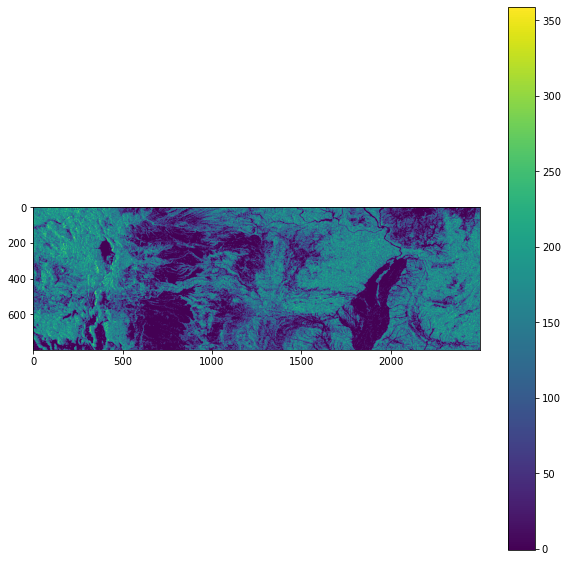

In [18]:
plt.figure(figsize = (10,10))
plt.imshow(aspect.ReadAsArray(), cmap='viridis')
plt.colorbar()

Be careful. The "no data" values are usually extreme, so if you plot outside the US, you will get a nonsense plot.

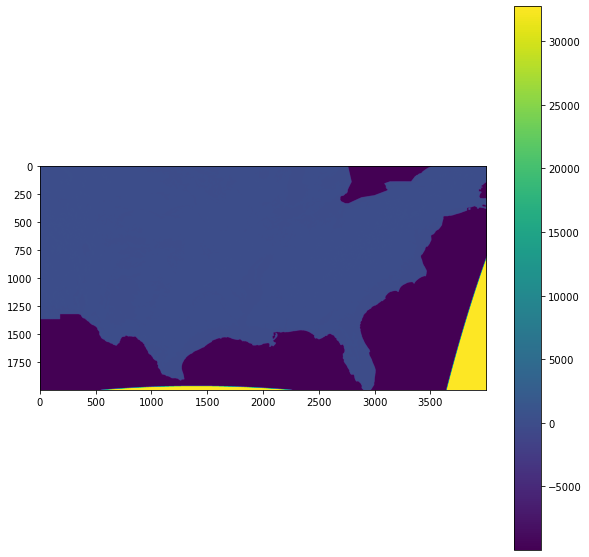

In [19]:
bounding_box = [-110, 25, -70, 45]
aspect = gdal.Warp(f'{layer}.vrt', ds, format='VRT', dstSRS='WGS84', xRes=0.01, yRes=0.01,
                  resampleAlg=row['impute'], outputBounds=bounding_box)
plt.figure(figsize = (10,10))
plt.imshow(aspect.ReadAsArray(), cmap='viridis')
plt.colorbar()

By changing the "layer" variable above, you can play around with slope as well. Note: GDAL is kind of buggy. If something seems weird (data not reading in, for example), try restarting the kernel and reading in the data again.